## 4 layers 3d cnn, 2 layer lstm, adadelta, using elu

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json

##### importing libraries

In [6]:
import pandas as pd
import numpy as np
from glob import glob
import skimage.transform
from skimage import io
from sklearn.preprocessing import OneHotEncoder
import joblib

import tensorflow as tf

#### Selecting Gestures

In [7]:
gesture_list = ['Swiping Right','Swiping Left','Thumb Up','Thumb Down','No gesture','Zooming In With Full Hand','Zooming Out With Full Hand']

#train
file_prefix = "new_jester_3DCNN_adadelta"
df = pd.read_csv('./annotations/jester-v1-train.csv',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_train.csv'.format(file_prefix),sep=';',index=False)
# pd.read_csv('jester-v1-8classes_train.csv',sep=";").head()
print(df.shape)
print(df.head())
#val
df = pd.read_csv('./annotations/jester-v1-validation.csv',sep=';',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_val.csv'.format(file_prefix),sep=';',index=False)
print(df.shape)
print(df.head())

print('Csvs done')

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size=2, image_dim=(256,256), frames_count=32, n_channels=1, base_dir='./20bn-jester-v1/', n_classes=27,validation=False):
        self.image_dim = image_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = True 
        self.frames_count = frames_count
        self.df = pd.read_csv(file_path,sep=";")
        self.df.id = self.df.id.map(str)
        if "train" in file_path:
            self.encoder = OneHotEncoder(sparse_output=False)
            self.encoder.fit(self.df.labels.values[:,None])
            joblib.dump(self.encoder,"{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
            np.save("encoder_classes_{}_npy.npy".format(n_classes),self.encoder.categories_)
        else:
            self.encoder = joblib.load("{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
        self.base_dir = base_dir
        self.on_epoch_end()

    def __len__(self):
        ## Decides step_size
        return self.df.shape[0] // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = self.df.loc[indexes,"id"].to_list()
        X, y = self.__data_generation(indexes)
        return X, y 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.df.shape[0])
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size,self.frames_count, *self.image_dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=str)
        y = []
        for i, ID in enumerate(indexes):
            files_list = self.standardize_frame_count(glob(self.base_dir + self.df.loc[ID,"id"] + "/*.jpg"),self.df.loc[ID])
            for idx,filename in enumerate(files_list):
                X[i,idx] = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename,color_mode='grayscale',target_size=self.image_dim))
            y.append(self.df.loc[ID,"labels"])
        encoded = self.encoder.transform(np.array(y)[:,None])
        return X,encoded
        
    def standardize_frame_count(self,files,error_check):
        shape = len(files)
        if shape < self.frames_count:
            to_add = self.frames_count - shape
            mid  = len(files)//2
            dup = [files[mid]]*to_add
            files = files[:mid] + dup + files[mid+1:]
        elif shape > self.frames_count:
            to_remove = (shape - self.frames_count)
            to_remove = int(to_remove) if int(to_remove) == to_remove else int(to_remove) + 1
            files = files[to_remove:]
        return files
    
params = {'batch_size': 56,
          'n_classes': len(gesture_list),
          'n_channels': 3,
          'image_dim': (32,32)
          }

# Generators
training_generator = DataGenerator(file_path="{}_train.csv".format(file_prefix),**params)
validation_generator = DataGenerator(file_path="{}_val.csv".format(file_prefix),**params)


(29819, 2)
        id                      labels
7   136859                    Thumb Up
8    68574               Swiping Right
13   20706                  No gesture
14   42237                  Thumb Down
19  133442  Zooming Out With Full Hand
(3640, 2)
       id                     labels
0    9223                   Thumb Up
2   42920               Swiping Left
3  106485                 Thumb Down
6   35341  Zooming In With Full Hand
7   94928              Swiping Right
Csvs done


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json
#from keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

In [9]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

#### Creating custom loss function

In [6]:
def custom_categorical_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0)  # Prevent log(0)
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Dropout, Dense, BatchNormalization, 
    GlobalAveragePooling3D, ConvLSTM2D, Flatten
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adadelta, SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2


In [8]:
input_shape = (36, 32, 32, 3)
weight_decay = 0.00005

In [9]:
def build_model(n_classes=7):
    momentum = 0.99
    
    model = Sequential()
    model.add(Conv3D(36, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=input_shape))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    model.add(Conv3D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Added Dropout after ConvLSTM layer
    
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dropout(0.3))  # Reduced dropout rate
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.01)))

    return model

# Building and compile the model
model = build_model(n_classes=len(gesture_list))
optimizer = Adadelta(learning_rate=1.0)  # You can adjust the learning rate as needed

model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(from_logits=True),  # Set from_logits=False for softmax activation
    metrics=['accuracy']
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
h = model.fit(
    training_generator,
    validation_data=validation_generator,
    validation_steps=32,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping]
)

# Save the model
def save_model(model, file_path):
    model_json = model.to_json()
    with open(file_path + '.json', "w") as json_file:
        json_file.write(model_json)
    model.save_weights(file_path + '.h5')

save_model(model, '{}_model'.format(file_prefix))

2024-10-28 12:14:29.809262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 12:14:29.809447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 12:14:29.809530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-10-28 12:14:34.547912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-28 12:15:08.755738: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0f6f1fcd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 12:15:08.755760: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-28 12:15:08.759852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 12:15:08.823799: I ./tenso

532/532 [==============================] - ETA: 0s - loss: 0.9542 - accuracy: 0.6485

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


532/532 [==============================] - 233s 365ms/step - loss: 0.9542 - accuracy: 0.6485 - val_loss: 0.7619 - val_accuracy: 0.7294
Epoch 2/50
532/532 [==============================] - 166s 313ms/step - loss: 0.5366 - accuracy: 0.8271 - val_loss: 0.5631 - val_accuracy: 0.8025
Epoch 3/50
532/532 [==============================] - 163s 305ms/step - loss: 0.3892 - accuracy: 0.8786 - val_loss: 0.4737 - val_accuracy: 0.8527
Epoch 4/50
532/532 [==============================] - 157s 296ms/step - loss: 0.3052 - accuracy: 0.9105 - val_loss: 0.3474 - val_accuracy: 0.8934
Epoch 5/50
532/532 [==============================] - 160s 300ms/step - loss: 0.2454 - accuracy: 0.9296 - val_loss: 0.4072 - val_accuracy: 0.8694
Epoch 6/50
532/532 [==============================] - 162s 304ms/step - loss: 0.1978 - accuracy: 0.9459 - val_loss: 0.3712 - val_accuracy: 0.8895
Epoch 7/50
532/532 [==============================] - 160s 300ms/step - loss: 0.1568 - accuracy: 0.9587 - val_loss: 0.3103 - val_accura

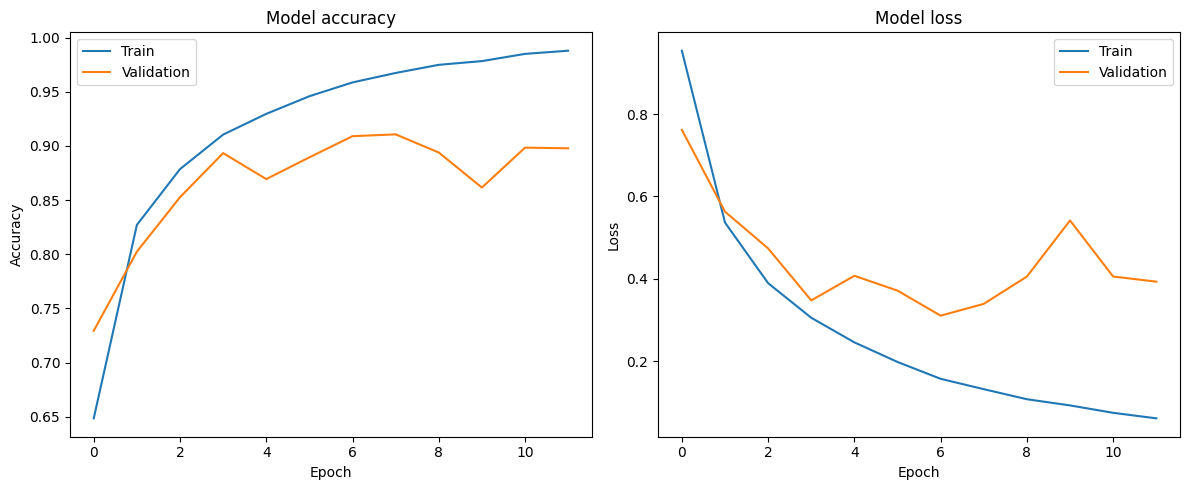

In [10]:
import matplotlib.pyplot as plt  

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [12]:
model.evaluate(validation_generator)


65/65 [==============================] - 19s 290ms/step - loss: 0.3397 - accuracy: 0.9055


[0.3396732807159424, 0.9054945111274719]

- ####  best accuracy